# VAE (Pansy flower)
* dataset: 17flowers (image_1281 to image_1360)

In [2]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import utils as vutils


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Create the dataset
dataroot = "data/17flowers"
workers = 2

image_size = 64
batch_size = 72

dataset = datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

train_dataset, valid_dataset = train_test_split(dataset, test_size=0.1)

# ? Create the dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)


Text(0.5, 1.0, 'Training Images')

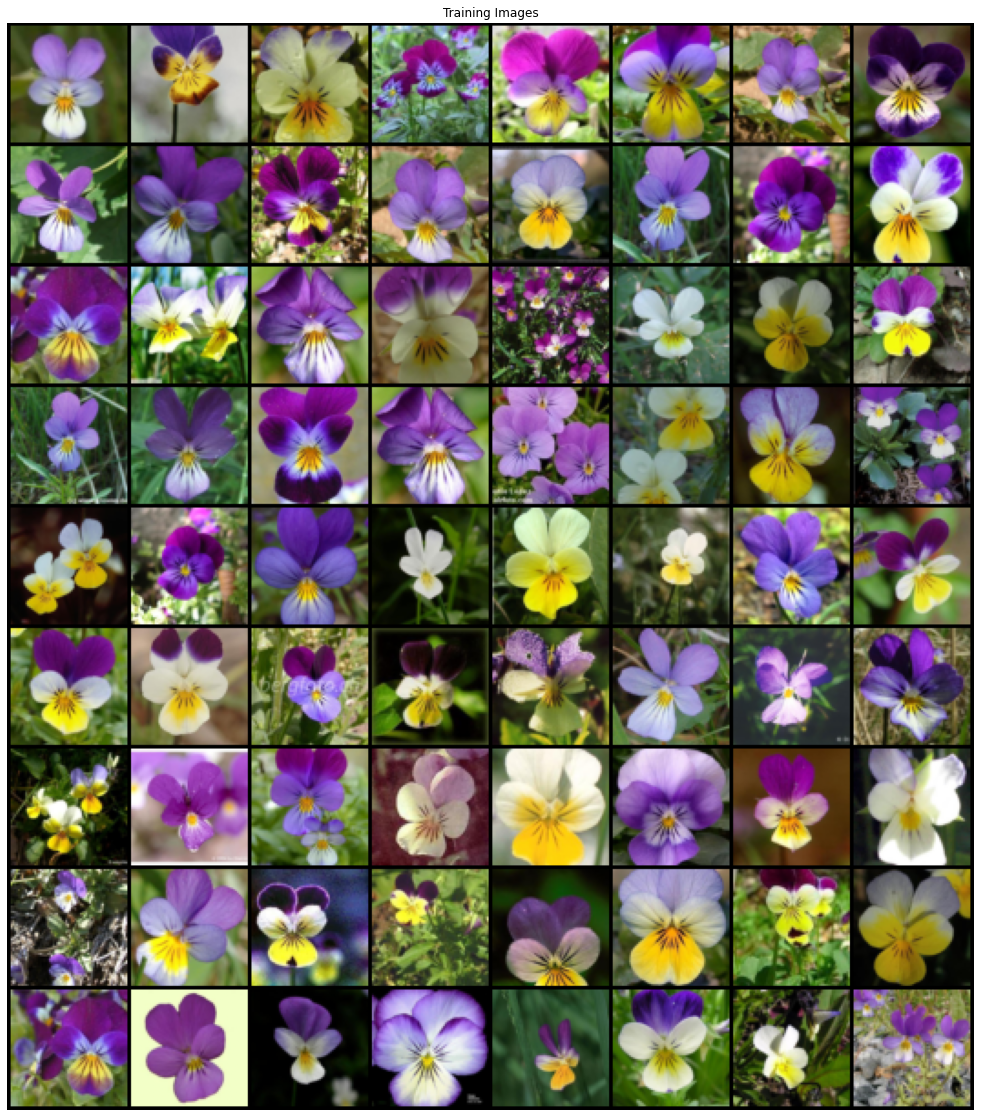

In [5]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=True), (1, 2, 0)))
plt.axis("off")
plt.title("Training Images")


In [13]:
class VAE(nn.Module):
    def __init__(self, image_size=64, channel_num=3, z_size=128):
        super().__init__()
        self.kernel_num = 128
        self.num_encoder_layers = 2

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channel_num, self.kernel_num // 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(self.kernel_num // 2, self.kernel_num, 4, 2, 1),
            nn.ReLU(),
        )

        # encoded feature's size and volume
        self.feature_size = image_size // (2 ** self.num_encoder_layers)
        self.feature_volume = self.kernel_num * (self.feature_size ** 2)

        self.q_mean = nn.Linear(self.feature_volume, z_size)
        self.q_logvar = nn.Linear(self.feature_volume, z_size)

        # projection
        self.project = nn.Linear(z_size, self.feature_volume)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.kernel_num, self.kernel_num // 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.kernel_num // 2, channel_num, 4, 2, 1),
            nn.ReLU(),
            nn.ReLU(),
        )

    def forward(self, x):
        # encode x
        encoded = self.encoder(x)

        mean, logvar = self.q(encoded)
        z = self.z(mean, logvar)
        z_projected = self.project(z).view(
            -1, self.kernel_num, self.feature_size, self.feature_size
        )
        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)
        return (mean, logvar, x_reconstructed)

    # ==============
    # VAE components
    # ==============

    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(torch.randn(std.size())).to(device)
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.MSELoss(size_average=False)(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean ** 2 + logvar.exp() - 1 - logvar) / 2).mean()


model = VAE().to(device)
print(model)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (q_mean): Linear(in_features=32768, out_features=128, bias=True)
  (q_logvar): Linear(in_features=32768, out_features=128, bias=True)
  (project): Linear(in_features=128, out_features=32768, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ReLU()
  )
)


In [14]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)


In [15]:
img_list = []

train_losses = []
val_losses = []

num_epochs = 500

print("Starting training loop...")
for epoch in range(num_epochs):
    train_loss = 0
    recon_loss = 0
    kl_loss = 0
    recon_batch = None

    val_loss = 0

    for i, (data, classes) in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        mu, logvar, recon_batch = model(data)

        reconstruction_loss = model.reconstruction_loss(recon_batch, data)
        kl_divergence_loss = model.kl_divergence_loss(mu, logvar)
        recon_loss += reconstruction_loss.item()
        loss = reconstruction_loss + kl_divergence_loss #+ 100*quantile_loss
        kl_loss += kl_divergence_loss.item()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    for i, (data, classes) in enumerate(valid_dataloader):
        with torch.no_grad():
            data = data.to(device)
            mu_val, logvar_val, recon_batch_val = model(data)
            reconstruction_loss_val = model.reconstruction_loss(recon_batch, data)
            kl_divergence_loss_val = model.kl_divergence_loss(mu, logvar)
            loss_val = reconstruction_loss_val + kl_divergence_loss_val
            val_loss += loss_val.item()

    train_loss /= len(train_dataloader) * batch_size
    val_loss /= len(valid_dataloader) * batch_size
    recon_loss /= len(train_dataloader) * batch_size
    kl_loss /= len(train_dataloader) * batch_size

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch}/{num_epochs}\t"
        f"Average loss: {train_loss:.4f}\t"
        f"Average Reconstruction loss: {recon_loss:.4f}\t"
        f"Average KL loss: {kl_loss:.4f}")

    if epoch % 10 == 0:
        img_list.append(vutils.make_grid(recon_batch.detach().cpu(), padding=2, normalize=True))
        vutils.save_image(img_list[-1], f"results/vaes/17flowers-pansy_{epoch}.png")


Starting training loop...


RuntimeError: DataLoader worker (pid(s) 27384, 78804) exited unexpectedly

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = np.array(np.transpose(i, (1, 2, 0)) for i in img_list)
print(len(img_list))
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

NameError: name 'plt' is not defined